In [2]:
using DifferentialEquations, Plots

## Linear ODE

In [193]:
# let's start with a simple, linear system

# here u is the state
# p are the paremeters of the model
# t is time
f(u, p, t) = 1.01*u

# u0 is the initial condition
u0 = 1/2

# tspan is a tuple that defines the time horizon
tspan = (0.0, 1.0)

# here is where we define the initial value problem
prob = ODEProblem(f, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

In [194]:
typeof(prob)

ODEProblem{Float64,Tuple{Float64,Float64},false,Nothing,ODEFunction{false,typeof(f),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem}

In [195]:
# here we actually solve the problem
# and we input the algorithm to compute the numerical solution
@time begin
    sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
end;

  0.697215 seconds (867.77 k allocations: 44.234 MiB, 5.31% gc time)


In [196]:
typeof(sol)

ODESolution{Float64,1,Array{Float64,1},Nothing,Nothing,Array{Float64,1},Array{Array{Float64,1},1},ODEProblem{Float64,Tuple{Float64,Float64},false,Nothing,ODEFunction{false,typeof(f),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem},Tsit5,OrdinaryDiffEq.InterpolationData{ODEFunction{false,typeof(f),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}}}

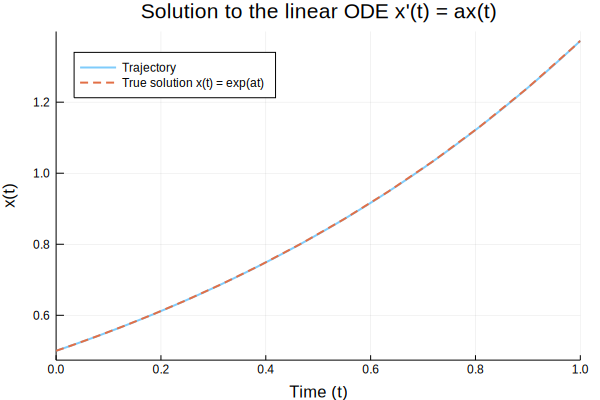

In [197]:
# the solution can be plotted using the plot recipe
plot(sol,linewidth=2,title="Solution to the linear ODE x'(t) = ax(t)",
     xaxis="Time (t)",yaxis="x(t)",label="Trajectory", alpha=.5)

plot!(sol.t, t->0.5*exp(1.01t), lw=2, ls=:dash,
      label="True solution x(t) = exp(at)", alpha=1., legend=:topleft)

### Solution using reachability

In [198]:
using Reachability, MathematicalSystems, LazySets, LaTeXStrings

In [203]:
S = LinearContinuousSystem(hcat(1.01))
X0 = Singleton([1/2.])

@time begin
    sol = Reachability.solve(IVP(S, X0), Options(:T=>1.0, :project_reachset=>true), op=BFFPSV18(:δ=>0.01));
end;

  0.021860 seconds (12.43 k allocations: 847.109 KiB)


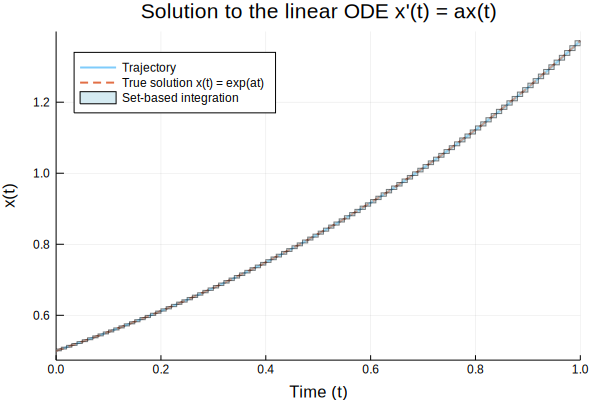

In [200]:
plot!(sol, alpha=.5, color=:lightblue, xaxis="Time (t)",yaxis="x(t)",label="Set-based integration")

Now, using the set-based simulation one can go further: consider a *interval* of initial conditions and compute the associated flowpipe, which encloses all the possible trajectories on the given interval.

In [204]:
S = LinearContinuousSystem(hcat(1.01))
X0 = Interval(0.49, 0.51)

@time begin
    sol = Reachability.solve(IVP(S, X0), Options(:T=>1.0, :project_reachset=>true), op=BFFPSV18(:δ=>0.01));
end;

  0.020967 seconds (12.44 k allocations: 848.000 KiB)


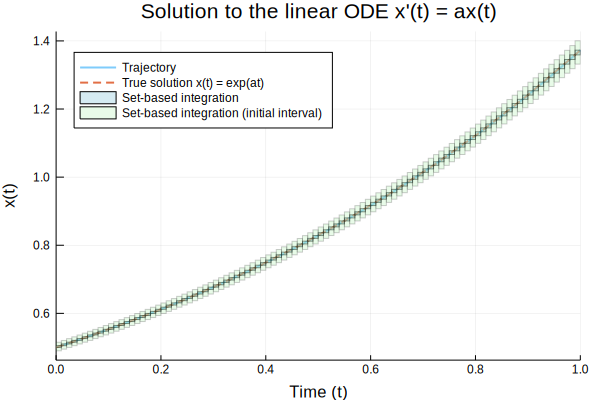

In [202]:
plot!(sol, alpha=.2, color=:lightgreen, xaxis="Time (t)",yaxis="x(t)",label="Set-based integration (initial interval)")

## Lorenz model

In [171]:
# the Lorentz model is a 3D system of ODEs that presents chaotic behavior

# du represents the derivatives of the flow
# u represents the state
# p are the parameters of the model
# t is time
function lorenz(du, u, p, t)
    du[1] = 10.0*(u[2]-u[1]) 
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz (generic function with 1 method)

In [172]:
# we define an initial condition
u0 = [1.0; 0.0; 0.0]

3-element Array{Float64,1}:
 1.0
 0.0
 0.0

In [173]:
tspan = (0.0, 100.0)

# here we let DifferentialEquations choose a default solver for us
prob = ODEProblem(lorenz, u0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [1.0, 0.0, 0.0]

In [ ]:
# we observe an important difference between this model and the previous one:
# In-place now is TRUE, before it was false.
# DifferentialEquations infers this from the signature of the function f

In [19]:
sol = DifferentialEquations.solve(prob);

In [25]:
sol.alg

CompositeAlgorithm{Tuple{Tsit5,Rosenbrock23{0,false,DiffEqBase.DefaultLinSolve,DataType}},AutoSwitch{Tsit5,Rosenbrock23{0,false,DiffEqBase.DefaultLinSolve,DataType},Rational{Int64},Float64}}((Tsit5(), Rosenbrock23{0,false,DiffEqBase.DefaultLinSolve,DataType}(DiffEqBase.DefaultLinSolve(nothing), Val{:forward})), AutoSwitch{Tsit5,Rosenbrock23{0,false,DiffEqBase.DefaultLinSolve,DataType},Rational{Int64},Float64}(-1326, Tsit5(), Rosenbrock23{0,false,DiffEqBase.DefaultLinSolve,DataType}(DiffEqBase.DefaultLinSolve(nothing), Val{:forward}), false, 10, 3, 9//10, 9//10, 2.0, false))

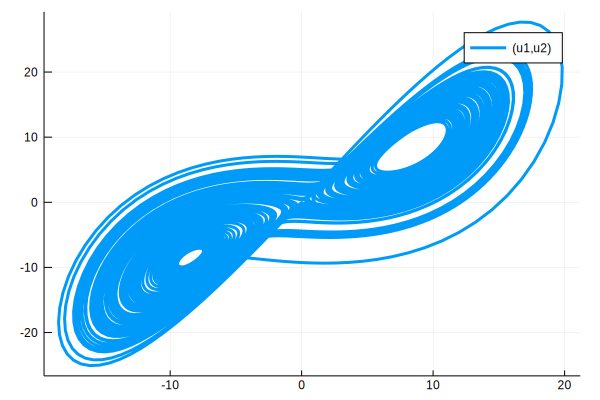

In [23]:
plot(sol, vars=(1, 2)) # to plot x1 vs x2

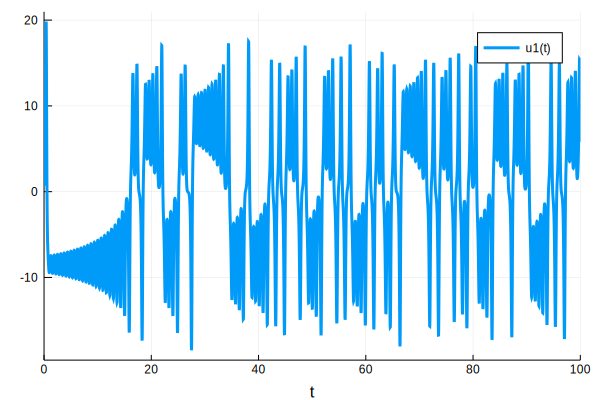

In [24]:
plot(sol, vars=(0, 1)) # to plot x1 vs time use "0"

## Solution using Reachability

In [ ]:
@taylorize function lorenz!(du, u, p, t)
    du[1] = 10.0*(u[2]-u[1]) 
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
end